<a href="https://colab.research.google.com/github/profsuccodifrutta/Variational_Autoencoder_for_Anomaly_Detection/blob/main/second_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Crea una cartella locale su Colab per i dati (veloce)
!mkdir -p /content/dataset_local

# Scompatta il file.
path_zip = "/content/drive/MyDrive/brainmri.zip"

!unzip -q "{path_zip}" -d /content/dataset_local

print("Scompattamento completato!")

replace /content/dataset_local/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/dataset_local/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Scompattamento completato!


In [ ]:
# Vediamo cosa c'è dentro la cartella locale
#!ls -R /content/dataset_local

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

In [29]:
import glob
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, random_split

# 1. Puntiamo ai dati sani
# Uso il percorso ricorsivo '**' per essere sicuri di trovarli ovunque siano
file_sani = glob.glob("/content/dataset_local/**/Training/notumor/*.jpg", recursive=True)

print(f"--- ANALISI DATASET ---")
print(f"Totale immagini sane trovate: {len(file_sani)}")

# 2. Classe Dataset
class BrainDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# 3. Creazione Split (70% Train, 20% Val, 10% Test)
if len(file_sani) > 0:
    full_healthy_ds = BrainDataset(file_sani)

    train_size = int(0.7 * len(full_healthy_ds))
    val_size = int(0.2 * len(full_healthy_ds))
    test_size = len(full_healthy_ds) - train_size - val_size

    train_subset, val_subset, test_healthy_subset = random_split(
        full_healthy_ds, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\n--- DISTRIBUZIONE SPLIT (Solo Sani) ---")
    print(f"✅ Training:   {len(train_subset)} immagini (usate per imparare la normalità)")
    print(f"⚠️ Validation: {len(val_subset)} immagini (usate per monitorare l'allenamento)")
    print(f"🛡️ Test Sani:  {len(test_healthy_subset)} immagini (usate per valutare i falsi allarmi)")

    # 4. Recuperiamo le anomalie per il Test finale
    file_anomalie = glob.glob("/content/dataset_local/**/Testing/*/*.jpg", recursive=True)
    # Filtriamo via i sani dalla cartella Testing per avere solo anomalie vere
    file_anomalie = [f for f in file_anomalie if "notumor" not in f]

    print(f"\n--- DATI PER TEST ANOMALIE ---")
    print(f"🚨 Anomalie:  {len(file_anomalie)} immagini (glioma, meningioma, etc.)")
else:
    print("❌ ERRORE: Non ho trovato le immagini. Controlla se la cartella 'Training/notumor' esiste.")

--- ANALISI DATASET ---
Totale immagini sane trovate: 1595

--- DISTRIBUZIONE SPLIT (Solo Sani) ---
✅ Training:   1116 immagini (usate per imparare la normalità)
⚠️ Validation: 319 immagini (usate per monitorare l'allenamento)
🛡️ Test Sani:  160 immagini (usate per valutare i falsi allarmi)

--- DATI PER TEST ANOMALIE ---
🚨 Anomalie:  906 immagini (glioma, meningioma, etc.)


In [ ]:
# Controlliamo la dimensione reale della prima immagine del dataset
img_raw = Image.open(train_subset.dataset.file_list[0])
print(f"La dimensione originale dei file è: {img_raw.size}")

La dimensione originale dei file è: (225, 225)


In [30]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# 1. TRASFORMAZIONI PER IL TRAINING (Con Data Augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5), # Specchiamento orizzontale
    transforms.RandomRotation(degrees=10),   # Piccola rotazione per simulare inclinazione testa
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)), # Traslazione e Zoom
    transforms.ToTensor(), # Converte in numero tra 0 e 1
])

# 2. TRASFORMAZIONI PER VALIDATION E TEST (Solo Base)
# Qui non vogliamo rotazioni, vogliamo vedere il dato "puro"
base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 3. WRAPPER PER APPLICARE LE TRASFORMAZIONI AI SUBSET
class TransformingDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # Prendiamo l'immagine originale dal subset
        x = self.subset[index]
        # Applichiamo la trasformazione specifica
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.subset)

# Creiamo i dataset finali "trasformati"
train_data = TransformingDataset(train_subset, transform=train_transform)
val_data = TransformingDataset(val_subset, transform=base_transform)
test_data_sani = TransformingDataset(test_healthy_subset, transform=base_transform)

# 4. CREAZIONE DATALOADERS
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader_sani = DataLoader(test_data_sani, batch_size=batch_size, shuffle=False)

print(f"I DataLoader sono pronti!")
print(f"Ogni batch contiene {batch_size} immagini di dimensione 128x128.")

I DataLoader sono pronti!
Ogni batch contiene 16 immagini di dimensione 128x128.


Formato del batch (Batch_size, Canali, Altezza, Larghezza): torch.Size([16, 1, 128, 128])


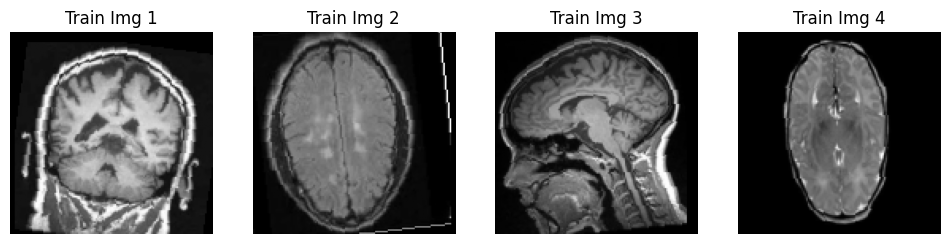

In [31]:
import matplotlib.pyplot as plt

# Estraiamo un batch (32 immagini) dal nostro motore di caricamento
images = next(iter(train_loader))

print(f"Formato del batch (Batch_size, Canali, Altezza, Larghezza): {images.shape}")

# Visualizziamo le prime 4 immagini per vedere l'effetto delle trasformazioni
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # Squeeze serve per passare da (1, 128, 128) a (128, 128) per il plot
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Train Img {i+1}")
    plt.axis('off')
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, latent_dim=512):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # ENCODER: Analisi profonda dell'immagine
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), # -> 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # -> 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # -> 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        # COLLO DI BOTTIGLIA (Latent Space)
        self.fc_mu = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(512 * 8 * 8, latent_dim)

        # DECODER: Ricostruzione dettagliata
        self.decoder_input = nn.Linear(latent_dim, 512 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> 128x128
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)

        de_input = self.decoder_input(z).view(-1, 512, 8, 8)
        reconstruction = self.decoder(de_input)
        return reconstruction, mu, logvar

# Inizializziamo il modello e lo spostiamo sulla GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=512).to(device)

save_path_v2 = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v2.pth"

print(f"Modello creato e inviato a: {device}")

Modello creato e inviato a: cuda


In [33]:
import torch.nn.functional as F
import time


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def vae_loss_function(recon_x, x, mu, logvar):
    # 1. Somma degli errori sui pixel
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # 2. KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # 3. Bilanciamento Beta
    beta = 0.001

    # 4. dividi  per il batch_size per non avere gradienti esplosivi
    return (recon_loss + beta * kl_loss) / x.size(0)


In [34]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, loader):
    model.eval()
    with torch.no_grad():
        # Prende un batch dal loader
        data = next(iter(loader))
        data = data.to(device)

        # Ottiene la ricostruzione
        recon, _, _ = model(data)

        # Plot dei primi 2 esempi
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        for i in range(2):
            # Originale
            axes[i, 0].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[i, 0].set_title("Originale")
            axes[i, 0].axis('off')

            # Ricostruito
            axes[i, 1].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title("Recon V2")
            axes[i, 1].axis('off')
        plt.show()

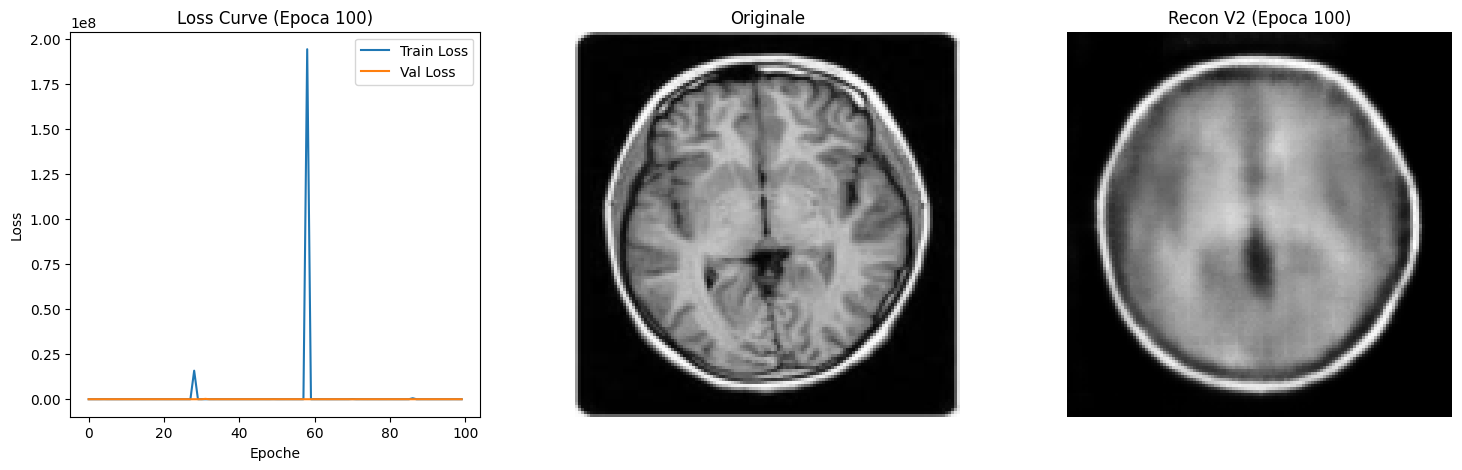

Epoca [100/100] | Train: 207.4382 | Val: 181.4911 | LR: 1.3e-04 


In [16]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Inizializziamo le liste per il plotting
train_losses = []
val_losses = []

print(f"Inizio Training V2 su {device}...")

for epoch in range(num_epochs):
    # --- FASE DI TRAINING ---
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = vae_loss_function(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_loader)
    train_losses.append(avg_train)

    # --- FASE DI VALIDAZIONE ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss = vae_loss_function(recon, batch, mu, logvar)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)

    # Aggiornamento Scheduler
    scheduler.step(avg_val)

    # Salvataggio miglior modello
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), save_path_v2)
        status_save = "Miglior modello salvato!"
    else:
        status_save = ""

    # --- VISUALIZZAZIONE E PLOT OGNI 10 EPOCHE ---
    if (epoch + 1) % 10 == 0 or epoch == 0:
        clear_output(wait=True) # Pulisce la cella per non creare una pagina lunghissima

        #  figura con due sottografici: Loss e Immagini
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Plot delle Loss
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Val Loss')
        ax1.set_title(f"Loss Curve (Epoca {epoch+1})")
        ax1.set_xlabel("Epoche")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # 2. Visualizzazione Ricostruzione (prendiamo un esempio dal val_loader)
        model.eval()
        with torch.no_grad():
            sample_batch = next(iter(val_loader)).to(device)
            sample_recon, _, _ = model(sample_batch)

            # Immagine Originale
            ax2.imshow(sample_batch[0].cpu().squeeze(), cmap='gray')
            ax2.set_title("Originale")
            ax2.axis('off')

            # Immagine Ricostruita
            ax3.imshow(sample_recon[0].cpu().squeeze(), cmap='gray')
            ax3.set_title(f"Recon V2 (Epoca {epoch+1})")
            ax3.axis('off')

        plt.show()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoca [{epoch+1}/{num_epochs}] | Train: {avg_train:.4f} | Val: {avg_val:.4f} | LR: {current_lr:.1e} {status_save}")

In [36]:
# caricamento rapido del modello V2

from google.colab import drive
import torch

# 1. Monta il Drive
drive.mount('/content/drive')

# 2. Definisci il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Inizializza il modello V2
model = VAE(latent_dim=512).to(device)

# 4. Carica i pesi salvati della V2
# Usa il nuovo percorso che abbiamo definito prima
model_path = "/content/drive/MyDrive/VAE_Brain_Project/best_model_v2.pth"

# Caricamento dei pesi
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Imposta in modalità valutazione (disabilita il training della BatchNorm)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=32768, out_features=512, bias=True)
  (fc_logvar): Linear(in_features=32

In [18]:
save_dir = "/content/drive/MyDrive/VAE_Brain_Project"

In [38]:

# per evitare di runnare tutto
import glob
from torch.utils.data import DataLoader

# 1. Recupera le liste dei file (Sostituisci i percorsi se diversi)
path_anomalie = "/content/dataset_local/Testing/*/*.jpg" # o il tuo percorso specifico
file_anomalie = glob.glob(path_anomalie)
file_sani_test = glob.glob("/content/dataset_local/Training/no/*.jpg")[:160] # Esempio

# 2. Ricrea i Loader
# Assicurati di aver eseguito la cella con "class BrainDataset" prima di questo!
anno_ds = BrainDataset(file_anomalie, transform=base_transform)
anno_loader = DataLoader(anno_ds, batch_size=16, shuffle=False)

test_sani_ds = BrainDataset(file_sani_test, transform=base_transform)
test_loader_sani = DataLoader(test_sani_ds, batch_size=16, shuffle=False)

print(f"✅ Liste e Loader ripristinati. Trovate {len(file_anomalie)} anomalie.")

✅ Liste e Loader ripristinati. Trovate 1311 anomalie.


✅ Modello V2 caricato correttamente da: /content/drive/MyDrive/VAE_Brain_Project/best_model_v2.pth
Soglia ottimale calcolata (Youden): inf
Miglior compromesso trovato: TPR=0.00, FPR=nan

--- PERFORMANCE SUL TEST SET (MODELLO V2) ---
              precision    recall  f1-score   support

        Sano       0.00      0.00      0.00       0.0
    Anomalia       0.00      0.00      0.00    1311.0

    accuracy                           0.00    1311.0
   macro avg       0.00      0.00      0.00    1311.0
weighted avg       0.00      0.00      0.00    1311.0

Area sotto la curva ROC (AUC): nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no tr

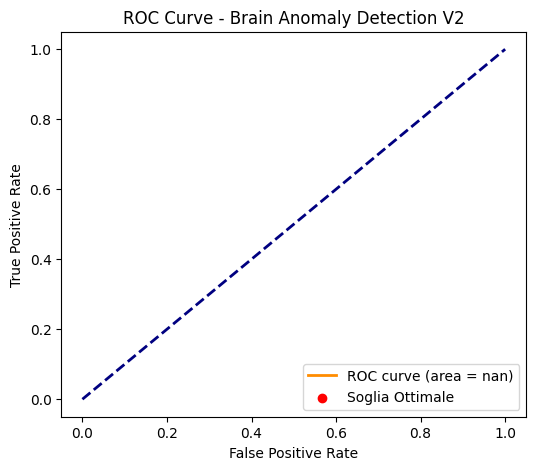

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def get_anomaly_scores(model, loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            # Calcoliamo l'errore MSE per ogni singola immagine
            mse = torch.mean((batch - recon)**2, dim=(1, 2, 3))
            scores.extend(mse.cpu().numpy())
    return np.array(scores)

# --- MODIFICA 1: Carichiamo il file della V2 ---
# Assicurati che save_path_v2 punti a "best_model_v2.pth"
model.load_state_dict(torch.load(save_path_v2, map_location=device))
model.eval()
print(f"✅ Modello V2 caricato correttamente da: {save_path_v2}")

# 2. Otteniamo i punteggi
test_healthy_scores = get_anomaly_scores(model, test_loader_sani)
test_anomaly_scores = get_anomaly_scores(model, anno_loader)

# 3. Creiamo i vettori per la valutazione
y_true = np.array([0] * len(test_healthy_scores) + [1] * len(test_anomaly_scores))
y_scores = np.concatenate([test_healthy_scores, test_anomaly_scores])

# 4. Calcolo della curva ROC e della soglia ottimale (Youden's J)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Se l'AUC è bassa (< 0.5), il modello sta invertendo le classi.
# L'indice di Youden troverà comunque il punto di massima separazione.
j_scores = tpr - fpr
optimal_idx = np.argmax(np.abs(j_scores)) # Usiamo abs per gestire casi invertiti
optimal_threshold = thresholds[optimal_idx]

print(f"Soglia ottimale calcolata (Youden): {optimal_threshold:.6f}")
print(f"Miglior compromesso trovato: TPR={tpr[optimal_idx]:.2f}, FPR={fpr[optimal_idx]:.2f}")

# 5. Valutazione finale
# Se j_scores era negativo, significa che le anomalie hanno errore PIÙ BASSO dei sani
if (np.mean(test_anomaly_scores) < np.mean(test_healthy_scores)):
    print("⚠️ Nota: Le anomalie hanno un errore medio inferiore ai sani. Il modello è invertito.")
    y_pred = [1 if s < optimal_threshold else 0 for s in y_scores]
else:
    y_pred = [1 if s > optimal_threshold else 0 for s in y_scores]

print("\n--- PERFORMANCE SUL TEST SET (MODELLO V2) ---")
print(classification_report(y_true, y_pred, target_names=['Sano', 'Anomalia']))
print(f"Area sotto la curva ROC (AUC): {roc_auc_score(y_true, y_scores):.4f}")

# 6. Visualizzazione Curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_true, y_scores):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Soglia Ottimale')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Brain Anomaly Detection V2')
plt.legend(loc="lower right")
plt.show()

Media Errore Sani: 0.010509
Media Errore Anomalie: 0.007048


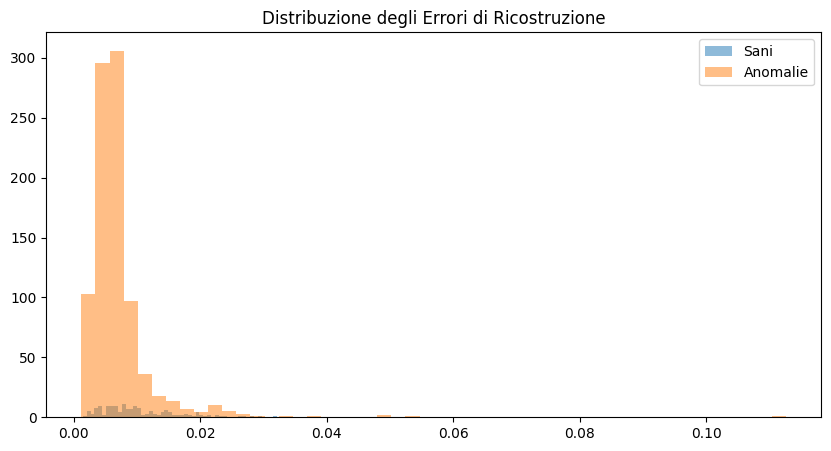

In [ ]:
print(f"Media Errore Sani: {test_healthy_scores.mean():.6f}")
print(f"Media Errore Anomalie: {test_anomaly_scores.mean():.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(test_healthy_scores, bins=50, alpha=0.5, label='Sani')
plt.hist(test_anomaly_scores, bins=50, alpha=0.5, label='Anomalie')
plt.legend()
plt.title("Distribuzione degli Errori di Ricostruzione")
plt.show()

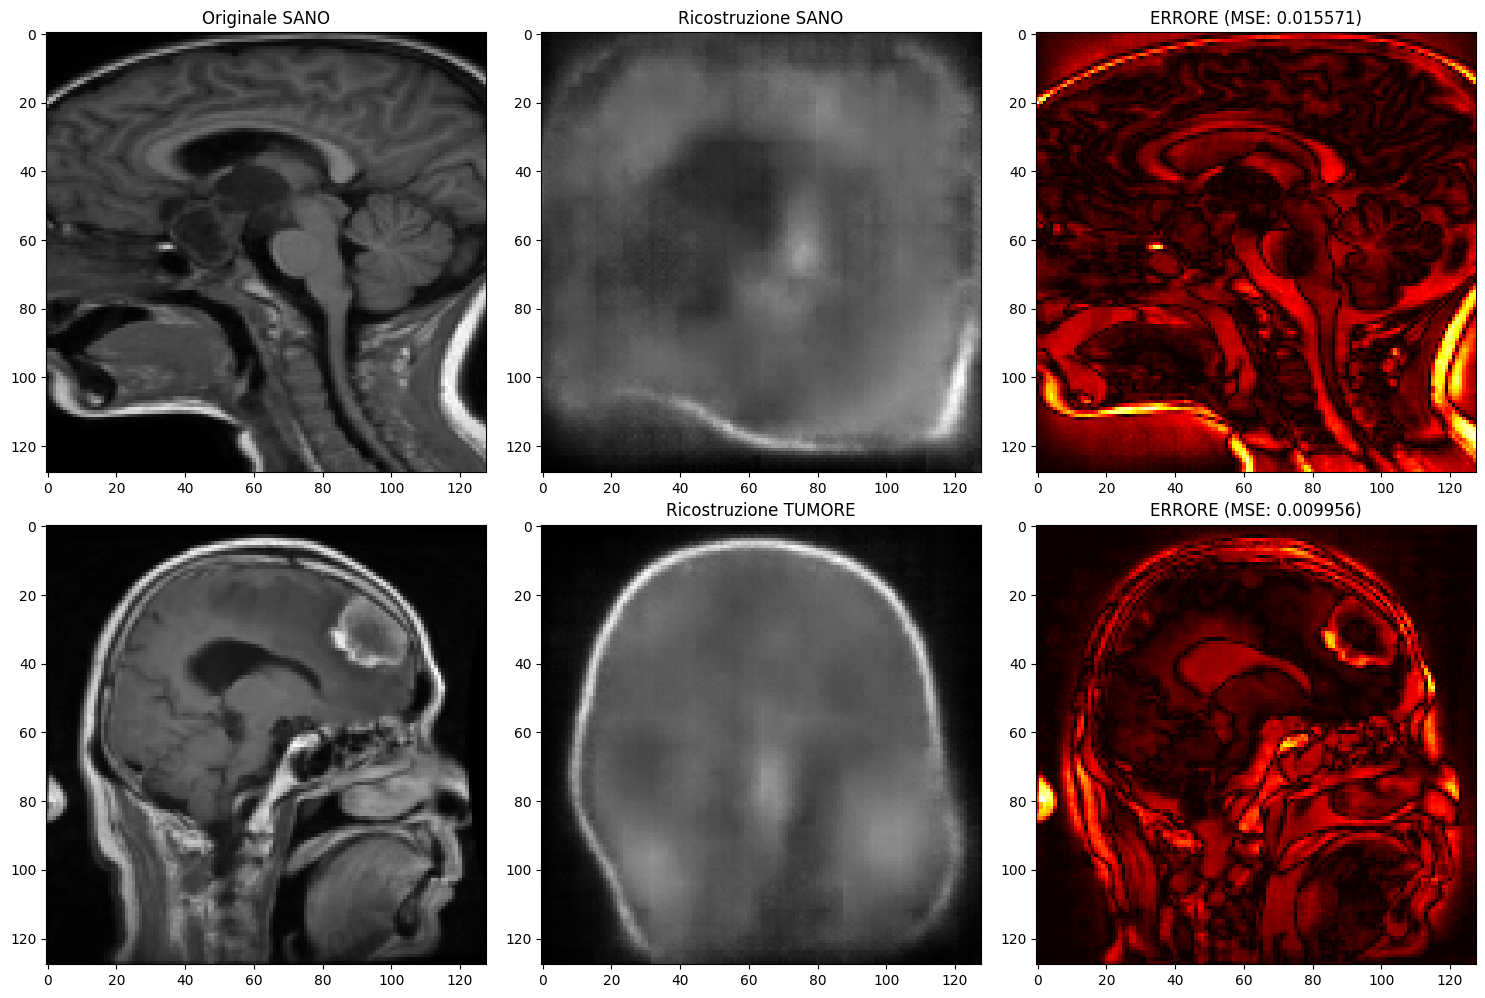

In [ ]:
def plot_debug_comparison(model, loader_sani, loader_anno):
    model.eval()
    with torch.no_grad():
        # Prendi un esempio sano e uno anomalo
        img_sano = next(iter(loader_sani))[0:1].to(device)
        img_anno = next(iter(loader_anno))[0:1].to(device)

        # Ricostruzioni
        rec_sano, _, _ = model(img_sano)
        rec_anno, _, _ = model(img_anno)

        # Mappe di differenza (errore assoluto)
        diff_sano = torch.abs(img_sano - rec_sano)
        diff_anno = torch.abs(img_anno - rec_anno)

        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Riga Sani
        axes[0,0].imshow(img_sano.cpu().squeeze(), cmap='gray'); axes[0,0].set_title("Originale SANO")
        axes[0,1].imshow(rec_sano.cpu().squeeze(), cmap='gray'); axes[0,1].set_title("Ricostruzione SANO")
        axes[0,2].imshow(diff_sano.cpu().squeeze(), cmap='hot'); axes[0,2].set_title(f"ERRORE (MSE: {torch.mean(diff_sano**2):.6f})")

        # Riga Anomalie
        axes[1,0].imshow(img_anno.cpu().squeeze(), cmap='gray'); axes[1,1].set_title("Originale TUMORE")
        axes[1,1].imshow(rec_anno.cpu().squeeze(), cmap='gray'); axes[1,1].set_title("Ricostruzione TUMORE")
        axes[1,2].imshow(diff_anno.cpu().squeeze(), cmap='hot'); axes[1,2].set_title(f"ERRORE (MSE: {torch.mean(diff_anno**2):.6f})")

        plt.tight_layout()
        plt.show()

plot_debug_comparison(model, test_loader_sani, anno_loader)

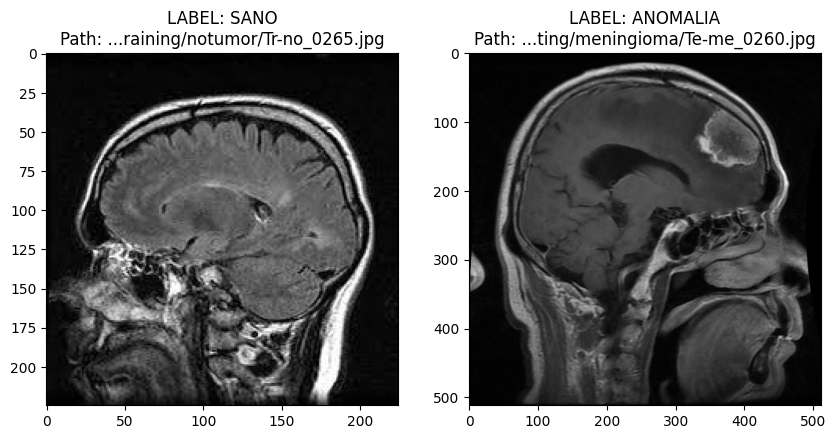

In [ ]:
# modello ha assegnato correttamente i labels?
def check_labels_integrity(file_sani_test, file_anomalie_test):
    plt.figure(figsize=(10, 5))

    # Prendi il primo file della lista test sani
    img_sana_path = file_sani_test[0]
    img_sana = Image.open(img_sana_path).convert('L')

    # Prendi il primo file della lista anomalie
    img_anno_path = file_anomalie_test[0]
    img_anno = Image.open(img_anno_path).convert('L')

    plt.subplot(1, 2, 1)
    plt.imshow(img_sana, cmap='gray')
    plt.title(f"LABEL: SANO\nPath: ...{img_sana_path[-30:]}")

    plt.subplot(1, 2, 2)
    plt.imshow(img_anno, cmap='gray')
    plt.title(f"LABEL: ANOMALIA\nPath: ...{img_anno_path[-30:]}")

    plt.show()

# Usiamo le liste originali dei file per il controllo
check_labels_integrity(test_healthy_subset.dataset.file_list, file_anomalie)